In [4]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager
import jieba
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.matutils import corpus2csc, corpus2dense

import pyLDAvis.gensim_models

from nltk import ngrams
from tqdm import tqdm

tqdm.pandas()

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 1: Load the data 載入資料</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Dataset Information 資料集資訊</div>

# PTT AI 討論資料集介紹

## 資料集概覽

此資料集包含有關 AI 的討論，收集自台灣的社群媒體平台 PTT。資料收集範圍從 2022 年 1 月 1 日到 2024 年 5 月 31 日，共包含 2,172 筆資料。

## 資料欄位說明

資料集包含以下 11 個欄位：

1. `system_id`: 系統編號，總共 2172 筆，無空值。
2. `artComment`: 文章評論，總共 2172 筆，無空值。
3. `artDate`: 文章日期，總共 2172 筆，無空值。
4. `insertedDate`: 插入日期，總共 2172 筆，無空值。
5. `artContent`: 文章內容，總共 2172 筆，無空值。
6. `artCatagory`: 文章類別，總共 2172 筆，無空值。
7. `dataSource`: 資料來源，總共 2172 筆，無空值，全部來自 PTT。
8. `artPoster`: 發文者，總共 2172 筆，無空值。
9. `artTitle`: 文章標題，總共 2172 筆，無空值。
10. `artUrl`: 文章網址，總共 2172 筆，無空值。

## 記憶體使用情況

- 資料集大小： 186.8+ KB
- 資料型態：整數 (int64) 1 欄，物件 (object) 9 欄

In [2]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [6]:
df = pd.read_csv("./data/ptt_ai_221130to240531.csv")  # 匯資料
df.head(3)

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/Finance/M.1644917373.A....,[徵才]普匯金融科技-金融科技行銷/金融實習生,2022-02-15 17:29:30,ggglu,Finance,【實習】\n【公司名稱】Influx FinTech 普匯金融科技\n\n【工作職缺】Fin...,"[{""cmtStatus"": ""噓"", ""cmtPoster"": ""cow38"", ""cmt...",118.168.142.101,2022-02-16 00:12:45,ptt
1,2,https://www.ptt.cc/bbs/Finance/M.1653071365.A....,[新聞]台銀「三駕馬車」戰略發威前4月,2022-05-21 02:29:23,make1302,Finance,（中央社記者張璦台北20日電）台灣銀行消金、企金、政府部門業務「三駕馬車」再發威\n，董事長...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""DerLuna"", ""c...",118.171.234.47,2022-05-22 01:11:41,ptt
2,3,https://www.ptt.cc/bbs/Finance/M.1676346325.A....,[新聞]央行徵才月薪最高86K,2023-02-14 11:45:19,kria5304,Finance,https://tinyurl.com/3fcp6ehh\n記者陳美君／台北報導\n2023...,"[{""cmtStatus"": ""噓"", ""cmtPoster"": ""fill725258"",...",36.224.200.45,2023-02-15 01:06:37,ptt


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2172 entries, 0 to 2171
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   system_id     2172 non-null   int64 
 1   artUrl        2172 non-null   object
 2   artTitle      2172 non-null   object
 3   artDate       2172 non-null   object
 4   artPoster     2172 non-null   object
 5   artCatagory   2172 non-null   object
 6   artContent    2172 non-null   object
 7   artComment    2172 non-null   object
 8   e_ip          2126 non-null   object
 9   insertedDate  2172 non-null   object
 10  dataSource    2172 non-null   object
dtypes: int64(1), object(10)
memory usage: 186.8+ KB


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Load the font 載入字型</div>

In [5]:
# Path to the custom font
font_path = 'font/TraditionalChinese.ttf'

# Add the custom font to the font manager
font_manager.fontManager.addfont(font_path)

# After adding the font, search for it by filename to get the correct font name
for font in font_manager.fontManager.ttflist:
    if font.fname == font_path:
        print(f"Found font: {font.name}")
        plt.rcParams['font.family'] = font.name
        break

Found font: Noto Sans TC


# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 2: Data Preprocessing 資料前處理</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Data Cleaning 資料清理</div>

In [8]:
# 移除網址格式
# 只留下中文字
df["artContent"] = df["artContent"].str.replace("(http|https)://.*", "", regex=True)
df["artTitle"] = df["artTitle"].str.replace("(http|https)://.*", "", regex=True)
df["artContent"] = df["artContent"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
df["artTitle"] = df["artTitle"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
df['content'] = df['artContent']


df = df.loc[:,["content", "artUrl", "artCatagory", 'artDate']]  # 文章內容 文章連結
df.head(3)

,content,artUrl,artCatagory,artDate
0,實習公司名稱普匯金融科技工作職缺徵求條件商管相關科系或曾經接觸相關領域關注時事議題對國內外金...,https://www.ptt.cc/bbs/Finance/M.1644917373.A....,Finance,2022-02-15 17:29:30
1,中央社記者張璦台北日電台灣銀行消金企金政府部門業務三駕馬車再發威董事長呂桔誠今天表示台銀今年...,https://www.ptt.cc/bbs/Finance/M.1653071365.A....,Finance,2022-05-21 02:29:23
2,記者陳美君台北報導年月日週二上午擁抱金飯碗的機會來了中央銀行近日公開徵才開出的職缺包括經濟金...,https://www.ptt.cc/bbs/Finance/M.1676346325.A....,Finance,2023-02-14 11:45:19


In [9]:
df=df.dropna(subset=['content'])

In [10]:
# 設定繁體中文詞庫
jieba.set_dictionary("./dict/dict.txt")
# 載入自定義辭典：一個詞一行，每行分詞語、詞頻(可省)、詞性(可省)
jieba.load_userdict("./dict/user_dict.txt")
# 新增stopwords
# #jieba.analyse.extract_tags才會作用
with open("./dict/stopwords.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

stopWords += [
    "的", "來", "對於", "愈來愈", "就是", "什麼",
    "空白", "00", "同義文字", "email", "站各級", "延長工時",
    "電子郵件", "市內電話", "條款", "限制", "應注意", "條文", "註明", "保",
    "詳盡", "資訊", "規範", "本條", "網站", "項", "留", "單位", "名稱", "法律",
    "條例", "使用者", "特殊", "條件", "時間", "內容", "其餘項目", "但不得", "本",
    "為每小時", "單位者", "為每小時", "依", "行", "相關", "第一項", "其他",
    "protected", "未註明", "現行法律", "其餘項留", "情況",
    "目前", "包含", "進行", "指出", "可以", "認為", "包括",
    "同時", "問題", "影響", "因此", "以及", "發展", "the", "and", '表示', '我們', '可能', '原文標題', '原文連結',
    '原文內容', 'in', 'on', 'for', 'that', 'our', '請務必',
    '心得評論', '工作', '使用', '現在', '已經', '因為', '自己', '透過', '他們', '提供', '開始', '不過', '需要',
    '記者署名', '去年', '成為', '針對', '如果', '甚至', '推出', '出現', '部分', '領域', '開發', '政府', '所以', '方式',
    '希望', '還是', '能力', '由於', '除了', '請具體', '方面', '獲得', '主要', '過去', '提升', '該公司', '資料', '此外',
    '報導', '生產', '能夠', '例如', '詳述狀況', '強調', '解決方案', '是否', '非常', '以上', '研究', '無法', '成功',
    '結果', '完成', '不同', '這樣', '如何', '機會', '安全', '數據', '處理', '研發', '宣布', '模型', '記者', '重要',
    '國家', '預估', '直接', '設備', '業者', '網路', '擁有', '之一', '另外', '利用', '必須', '支持', '成本', '應用',
    '一個', '人工智慧', 'AI', '公司', '市場', '億美元', '美元', 'rs', '這些', '表現', 'of', '持續', '雖然', '億元',
    '根據', '團隊', '隨著', '客戶', '其中', 'to', '這個', '未來', '平台', '產業', '產品', '今年', '今天', '預計',
    '預期',
    '年月日', '週日', '上午', '至止', '週一', '擁抱', '驅動', '一週', '路號', '三天', '曾經', '接觸', '加分具', '一起',
    '並由', '午休', '三天', '下午', '備註',
    '公司簡介', '小時', '具備', '一起', '原文'
]


# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

# df["words"] = df["content"].apply(getToken)
# df.head(5)

Building prefix dict from D:\GitHub\SocialMediaAnalysisAboutAITrend\dict\dict.txt ...
2025-07-28 16:25:29,277 : DEBUG : Building prefix dict from D:\GitHub\SocialMediaAnalysisAboutAITrend\dict\dict.txt ...
Dumping model to file cache C:\Users\eddie\AppData\Local\Temp\jieba.ub597ddb100a85c4b52bbc06e3b7935c2.cache
2025-07-28 16:25:29,922 : DEBUG : Dumping model to file cache C:\Users\eddie\AppData\Local\Temp\jieba.ub597ddb100a85c4b52bbc06e3b7935c2.cache
Loading model cost 0.698 seconds.
2025-07-28 16:25:29,977 : DEBUG : Loading model cost 0.698 seconds.
Prefix dict has been built successfully.
2025-07-28 16:25:29,979 : DEBUG : Prefix dict has been built successfully.


# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 3: Data Analysis 資料分析</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Bi-Gram</div>

In [11]:
# 設定 ngram 斷詞 function
def ngram_getToken(row, n):
    # 進行斷詞
    seg_list = jieba.lcut(row)

    # 篩選掉停用字與字元數小於1的詞彙
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1]

    # ngram斷詞
    seg_list = ngrams(seg_list, n)
    seg_list = ["".join(w) for w in list(seg_list)]

    return seg_list

In [12]:
df_bigram = df.copy()

df_bigram["word"] = df_bigram['content'].progress_apply(lambda row: ngram_getToken(row, 2))
df_bigram = df_bigram.explode('word')

df_bigram.head(3)

100%|██████████| 2172/2172 [00:40<00:00, 53.43it/s]


,content,artUrl,artCatagory,artDate,word
0,實習公司名稱普匯金融科技工作職缺徵求條件商管相關科系或曾經接觸相關領域關注時事議題對國內外金...,https://www.ptt.cc/bbs/Finance/M.1644917373.A....,Finance,2022-02-15 17:29:30,實習普匯
0,實習公司名稱普匯金融科技工作職缺徵求條件商管相關科系或曾經接觸相關領域關注時事議題對國內外金...,https://www.ptt.cc/bbs/Finance/M.1644917373.A....,Finance,2022-02-15 17:29:30,普匯金融
0,實習公司名稱普匯金融科技工作職缺徵求條件商管相關科系或曾經接觸相關領域關注時事議題對國內外金...,https://www.ptt.cc/bbs/Finance/M.1644917373.A....,Finance,2022-02-15 17:29:30,金融科技


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">統計最常出現的 Bi-Gram 組合</div>

In [13]:
# 計算每個組合出現的次數
df_bigram_count = df_bigram['word'].value_counts().reset_index()

df_bigram_count.sort_values('count', ascending=False).head(20)

,word,count
0,食衣住行育樂省錢妙招,168
1,省錢妙招具體,168
2,執行長黃仁勳,140
3,發布經濟日報,100
4,輝達股價,99
5,具體疫情,96
6,務必詳述職場經歷現況,90
7,輝達執行長,87
8,疫情關係,86
17,性別平等工作法,85


In [14]:
high_freq_pairs = df_bigram_count[df_bigram_count['count'] > 10].values.tolist()
high_freq_pairs += [['約聘計時人員',70],['輝達執行長仁勳',77]]
high_freq_pairs[:10]

[['食衣住行育樂省錢妙招', 168],
 ['省錢妙招具體', 168],
 ['執行長黃仁勳', 140],
 ['發布經濟日報', 100],
 ['輝達股價', 99],
 ['具體疫情', 96],
 ['務必詳述職場經歷現況', 90],
 ['輝達執行長', 87],
 ['疫情關係', 86],
 ['文責自負', 85]]

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">更新斷詞字典</div>

In [15]:
# 更新斷詞字典
for word, freq in high_freq_pairs:
    jieba.add_word(word, freq=freq)

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">重新斷詞</div>

In [16]:
# 重新斷詞
df["words"] = df["content"].apply(getToken)
df.head(5)

,content,artUrl,artCatagory,artDate,words
0,實習公司名稱普匯金融科技工作職缺徵求條件商管相關科系或曾經接觸相關領域關注時事議題對國內外金...,https://www.ptt.cc/bbs/Finance/M.1644917373.A....,Finance,2022-02-15 17:29:30,"[實習, 普匯, 金融科技, 職缺, 徵求, 商管, 科系, 關注, 時事, 議題, 國內外..."
1,中央社記者張璦台北日電台灣銀行消金企金政府部門業務三駕馬車再發威董事長呂桔誠今天表示台銀今年...,https://www.ptt.cc/bbs/Finance/M.1653071365.A....,Finance,2022-05-21 02:29:23,"[中央社, 張璦, 台北日電, 台灣, 銀行, 消金, 企金, 部門, 業務, 三駕, 馬車..."
2,記者陳美君台北報導年月日週二上午擁抱金飯碗的機會來了中央銀行近日公開徵才開出的職缺包括經濟金...,https://www.ptt.cc/bbs/Finance/M.1676346325.A....,Finance,2023-02-14 11:45:19,"[陳美君, 台北, 週二, 金飯碗, 中央, 銀行, 近日, 公開, 徵才, 開出, 職缺,..."
3,證交所徵才開創數位驅動時代報名至止中央社年月日週一下午中央社記者潘智義台北年月日電台灣證券交...,https://www.ptt.cc/bbs/Finance/M.1698684536.A....,Finance,2023-10-31 00:48:54,"[證交所, 徵才, 開創, 數位, 時代, 報名, 中央社, 中央社, 潘智義, 台北, 日..."
4,版禁止張貼違反就業服務法性別平等工作法勞基法與其他法律之文章發文者已同意一切遵循現行法律並確...,https://www.ptt.cc/bbs/job/M.1641165773.A.E67....,job,2022-01-03 07:22:51,"[禁止張貼, 違反就業, 服務法性別平等, 工作法勞基法, 文章發文, 同意, 確知文責, ..."


# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 4: LDA Modeling LDA 主題模型</div>

In [17]:
docs = df['words'].to_list()
docs[0]

['實習',
 '普匯',
 '金融科技',
 '職缺',
 '徵求',
 '商管',
 '科系',
 '關注',
 '時事',
 '議題',
 '國內外',
 '金融',
 '科技趨勢',
 '議題',
 '興趣',
 '熟悉',
 '軟體',
 '社群',
 '軟體',
 '圖文',
 '影音',
 '創作',
 '額外',
 '加分',
 '經驗',
 '額外',
 '加分',
 '操作',
 '過線',
 '上線',
 '行銷活動',
 '媒體',
 '經營',
 '經驗',
 '額外',
 '加分',
 '薪資待遇',
 '實習',
 '連絡',
 '投遞履歷',
 '地點',
 '台北市中山區',
 '松江路',
 '號樓',
 '週三',
 '天可議',
 '一小時',
 '指導',
 '協助',
 '廣告',
 '投放',
 '社群',
 '經營',
 '圖文',
 '撰寫',
 '行銷',
 '提案',
 '執行',
 '蒐集',
 '分析',
 '福利',
 '三節',
 '獎品',
 '簡介',
 '普匯',
 '金融科技',
 '專業',
 '風險管理',
 '金融',
 '設計',
 '高端',
 '科技',
 '組成',
 '互利',
 '互信',
 '公開',
 '透明',
 '溫度',
 '金融服務',
 '立志',
 '串起',
 '社會',
 '閒置',
 '資源',
 '協助',
 '年輕人',
 '夢想',
 '金融',
 '一支',
 '最具',
 '速度',
 '紀律',
 '績效',
 '邀請',
 '加入',
 '開創',
 '年輕',
 '移動',
 '金融服務',
 '共同',
 '邁向',
 '國際',
 '舞台',
 '創立',
 '金融科技',
 '獨角獸',
 '高端',
 '科技',
 '區塊',
 '技術',
 '中小企業',
 '汽車',
 '融資',
 '線上',
 '借貸',
 '債權',
 '投資',
 '媒合',
 '服務',
 '創新',
 '金融',
 '跨業',
 '策略',
 '聯盟',
 '金融科技',
 '聯盟',
 '合作',
 '台大',
 '兒童',
 '健康',
 '基金會',
 '張鈞甯',
 '擔任',
 '公益',
 '大使',
 '舉辦',
 '聯合',
 '勸募'

In [18]:
dictionary = Dictionary(docs)
# Filter out words that occur less than 5 documents, or more than 99% of the documents.
dictionary.filter_extremes(no_below=5, no_above=0.99)
print(dictionary)

2025-07-28 16:29:43,813 : INFO : adding document #0 to Dictionary<0 unique tokens: []>
2025-07-28 16:29:44,202 : INFO : built Dictionary<39434 unique tokens: ['一小時', '一支', '三節', '上線', '中小企業']...> from 2172 documents (total 468050 corpus positions)
2025-07-28 16:29:44,203 : INFO : Dictionary lifecycle event {'msg': "built Dictionary<39434 unique tokens: ['一小時', '一支', '三節', '上線', '中小企業']...> from 2172 documents (total 468050 corpus positions)", 'datetime': '2025-07-28T16:29:44.203304', 'gensim': '4.3.0', 'python': '3.8.19 (default, Mar 20 2024, 19:55:45) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19045-SP0', 'event': 'created'}
2025-07-28 16:29:44,240 : INFO : discarding 29148 tokens: [('串起', 2), ('互信', 1), ('債權', 1), ('公益', 3), ('勸募', 1), ('商管', 4), ('天可議', 1), ('張鈞甯', 1), ('心動', 4), ('捐款', 3)]...
2025-07-28 16:29:44,240 : INFO : keeping 10286 tokens which were in no less than 5 and no more than 2150 (=99.0%) documents
2025-07-28 16:29:44,262 : INFO : resulting dictionar

Dictionary<10286 unique tokens: ['一小時', '一支', '三節', '上線', '中小企業']...>


In [19]:
for idx, (k, v) in enumerate(dictionary.token2id.items()):
    print(f"{k}: {v}")
    if idx > 10:
        break

一小時: 0
一支: 1
三節: 2
上線: 3
中小企業: 4
互利: 5
借貸: 6
健康: 7
兒童: 8
公開: 9
共同: 10
分析: 11


In [20]:
# Bag-of-words representation of the documents.
# 用 gensim ldamodel input 需要將文章轉換成 bag of words
corpus = [dictionary.doc2bow(doc) for doc in docs]

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">訓練topic model</div>

##### 透過指標找出最佳主題數

In [21]:
t0 = time.time()

topic_num_list = np.arange(2, 10)
result = {"topic_num":[], "perplexity":[], "pmi":[]}
model_set = dict()


for topic_num in tqdm(topic_num_list, desc="Processing Topics"):
    # perplexity
    model = LdaMulticore(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=dictionary,
        workers=2,
        random_state = 1500,
        iterations=100,
        passes=5 # 訓練次數
        )

    loss = model.log_perplexity(corpus)
    pmi = CoherenceModel(model=model, texts=docs, coherence='c_npmi').get_coherence()
    perplexity = np.exp(-1. * loss)

    # model_set[f'k_{topic_num}'] = model

    result['topic_num'].append(topic_num)
    result['perplexity'].append(perplexity)
    result['pmi'].append(pmi)

print(f"花費時間: {time.time() - t0} sec")

### 花費時間: 270.542920589447 sec

Processing Topics:   0%|          | 0/8 [00:00<?, ?it/s]2025-07-28 16:30:11,970 : INFO : using symmetric alpha at 0.5
2025-07-28 16:30:11,971 : INFO : using symmetric eta at 0.5
2025-07-28 16:30:11,973 : INFO : using serial LDA version on this node
2025-07-28 16:30:11,975 : INFO : running online LDA training, 2 topics, 5 passes over the supplied corpus of 2172 documents, updating every 4000 documents, evaluating every ~2172 documents, iterating 100x with a convergence threshold of 0.001000
2025-07-28 16:30:11,975 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2025-07-28 16:30:11,976 : INFO : training LDA model using 2 processes
2025-07-28 16:30:14,543 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/2172, outstanding queue size 1
2025-07-28 16:30:14,590 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #2172/2172, outstanding queue size 2
2025-07-28 16:30:16,762 : 

花費時間: 270.542920589447 sec


In [22]:
result = pd.DataFrame(result)
result

,topic_num,perplexity,pmi
0,2,3790.030796,-0.011238
1,3,3660.881109,-0.005650
2,4,3611.399943,0.000772
3,5,3471.242506,-0.041272
4,6,3413.974836,-0.036319
5,7,3425.340137,-0.035147
6,8,3518.016839,-0.045419
7,9,3520.522248,-0.036532


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">分析 Perplexity</div>

Perplexity 實務建議
- 一般我們會選擇「Perplexity 趨於平緩」甚至最低的主題數，作為主題模型的最佳主題數候選。
- 但 Perplexity 不一定和語意一致性（如 PMI）完全一致。有時困惑度最低的主題數，產生的主題語意未必最清楚，所以會和 PMI 等指標綜合考慮。

<Axes: xlabel='topic_num'>

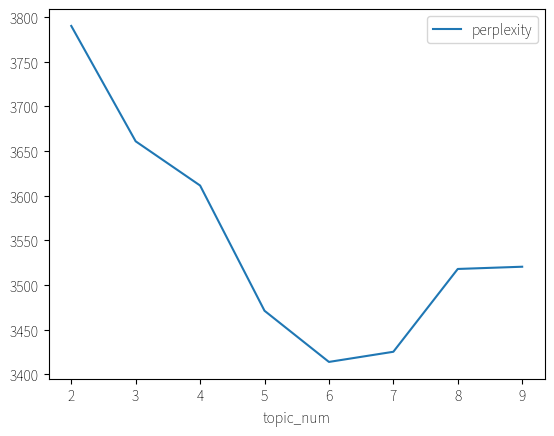

In [23]:
result.plot.line(x='topic_num', y='perplexity')

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">分析 Pointwise Mutual Information</div>

PMI 的直觀解釋
- PMI（點對互信息） 衡量的是兩個詞同時出現的可能性，與這兩個詞獨立出現的可能性的比值。如果 PMI 值高，表示這兩個詞在同一主題內「比隨機情況下更常」一起出現，也就是語意上關聯較強。
- 在 LDA 主題建模裡，PMI 通常用來評估主題的質量，即一組主題內關鍵詞彼此的語意一致性。

<Axes: xlabel='topic_num'>

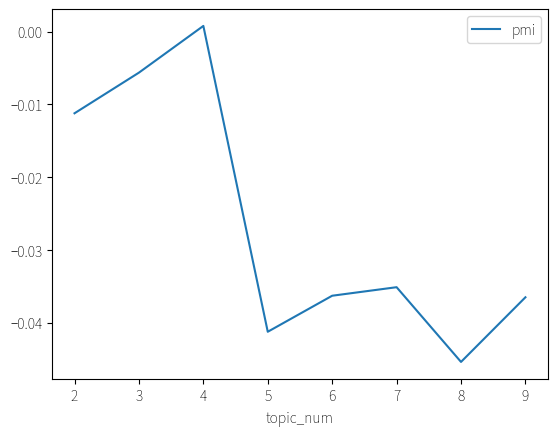

In [24]:
result.plot.line(x='topic_num', y='pmi')

理想狀況是找到一個使 Perplexity 低、PMI 高的主題數，但實際上二者常常衝突。

- topic_num = 6：Perplexity 最低，但 PMI 已明顯下降，語意聚合度變差。
- topic_num = 4：PMI 最好，但 Perplexity 還沒最低。

通常建議兩種方法：

- 若偏重機率預測或下游自動化應用（文件分類、推薦）→ 選 topic_num = 6。
- 若偏重語意解釋性（主題詞更明確、主題更有意義）→ 選 topic_num = 4。

我們這選擇 6 個做為範例，請根據你觀測的分析

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 5: Visualization 視覺化呈現</div>

In [25]:
best_model = LdaMulticore(
    corpus=corpus,
    num_topics=6,
    id2word=dictionary,
    workers=2,
    random_state=1500,
    iterations=100,
    passes=10  # 訓練次數
)
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(best_model, corpus, dictionary)
p

2025-07-28 16:46:01,408 : INFO : using symmetric alpha at 0.16666666666666666
2025-07-28 16:46:01,409 : INFO : using symmetric eta at 0.16666666666666666
2025-07-28 16:46:01,411 : INFO : using serial LDA version on this node
2025-07-28 16:46:01,416 : INFO : running online LDA training, 6 topics, 10 passes over the supplied corpus of 2172 documents, updating every 4000 documents, evaluating every ~2172 documents, iterating 100x with a convergence threshold of 0.001000
2025-07-28 16:46:01,418 : INFO : training LDA model using 2 processes
2025-07-28 16:46:04,024 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/2172, outstanding queue size 1
2025-07-28 16:46:04,076 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #2172/2172, outstanding queue size 2
2025-07-28 16:46:06,476 : INFO : topic #0 (0.167): 0.012*"輝達" + 0.008*"台積電" + 0.008*"晶片" + 0.005*"台灣" + 0.005*"美國" + 0.005*"伺服器" + 0.004*"技術" + 0.004*"發布" + 0.004*"中國" + 0.004*"科技"
2025-07-28 16:46:06,478 :

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.031042 -0.078497       1        1  19.740792
2     -0.017064 -0.153633       2        1  19.399218
3     -0.107427  0.125336       3        1  19.124995
1     -0.056195 -0.075611       4        1  18.460801
0     -0.108861  0.126487       5        1  17.591683
4      0.320589  0.055918       6        1   5.682511, topic_info=     Term         Freq        Total Category  logprob  loglift
4754   輝達  1731.000000  1731.000000  Default  30.0000  30.0000
1907  台積電  2129.000000  2129.000000  Default  29.0000  29.0000
416    具體   517.000000   517.000000  Default  28.0000  28.0000
1178   美國  2145.000000  2145.000000  Default  27.0000  27.0000
3359   中國  1479.000000  1479.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
479    應徵    67.498752   174.372704   Topic6  -5.8487   1.9187
1367   行動    70.430261   261.104781   Topic6  -5.8062   1.5575
1701   穩定    67.752292   273.743969   Topic6  -5.8449   1.4714
2299   收入    68.109015   341.683784   Topic6  -5.8397   1.2550
543    計畫    64.900363   725.376691   Topic6  -5.8879   0.4539

[498 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
1984      6  0.958091  一年退文
1985      6  0.963554  一律砍除
889       1  0.086803    一種
889       2  0.705275    一種
889       3  0.014467    一種
...     ...       ...   ...
5751      2  0.403174   黃仁勳
5751      3  0.007753   黃仁勳
5751      4  0.040705   黃仁勳
5751      5  0.494276   黃仁勳
5751      6  0.001938   黃仁勳

[1541 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 3, 4, 2, 1, 5])

可以看到(3, 5),(1, 4)很相近，試試看跑 4 個主題
在此步驟目的是根據實際分布範圍聚合部分 Topic，將重疊 Topic 合併

In [26]:
num_topics = 4
num_words = 10

manual_model = LdaMulticore(
    corpus=corpus,
    num_topics=4,
    id2word=dictionary,
    workers=2,
    random_state=1500,
    iterations=100,
    passes=10  # 訓練次數
)

for i in range(num_topics):
    print(f"主題 {i + 1}:")
    topic_words = manual_model.show_topic(i, num_words)
    for word, prob in topic_words:
        print(f"{word}: {prob:.4f}")
    print("\n")

pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(manual_model, corpus, dictionary)
p

2025-07-28 16:48:27,937 : INFO : using symmetric alpha at 0.25
2025-07-28 16:48:27,938 : INFO : using symmetric eta at 0.25
2025-07-28 16:48:27,939 : INFO : using serial LDA version on this node
2025-07-28 16:48:27,943 : INFO : running online LDA training, 4 topics, 10 passes over the supplied corpus of 2172 documents, updating every 4000 documents, evaluating every ~2172 documents, iterating 100x with a convergence threshold of 0.001000
2025-07-28 16:48:27,944 : INFO : training LDA model using 2 processes
2025-07-28 16:48:30,599 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/2172, outstanding queue size 1
2025-07-28 16:48:30,653 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #2172/2172, outstanding queue size 2
2025-07-28 16:48:32,854 : INFO : topic #0 (0.250): 0.009*"輝達" + 0.008*"晶片" + 0.007*"台積電" + 0.006*"美國" + 0.005*"台灣" + 0.005*"中國" + 0.005*"技術" + 0.004*"伺服器" + 0.004*"投資" + 0.004*"發布"
2025-07-28 16:48:32,856 : INFO : topic #1 (0.250): 0.00

主題 1:
美國: 0.0133
輝達: 0.0132
晶片: 0.0113
中國: 0.0102
台積電: 0.0070
投資: 0.0065
發布: 0.0052
台灣: 0.0044
台股: 0.0044
股價: 0.0043


主題 2:
技術: 0.0077
企業: 0.0067
具體: 0.0066
科技: 0.0062
人才: 0.0059
台灣: 0.0049
投資: 0.0047
機器人: 0.0044
馬斯克: 0.0043
元宇宙: 0.0041


主題 3:
技術: 0.0067
系統: 0.0058
生成: 0.0042
訓練: 0.0041
分析: 0.0036
人類: 0.0034
專利: 0.0032
工程師: 0.0031
軟體: 0.0030
程式: 0.0030


主題 4:
台積電: 0.0116
台灣: 0.0101
成長: 0.0058
需求: 0.0055
半導體: 0.0054
技術: 0.0053
營收: 0.0052
晶片: 0.0051
全球: 0.0049
聯發科: 0.0041




PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.107259 -0.041767       1        1  29.056056
2     -0.142586 -0.083152       2        1  27.526429
3      0.121267  0.016211       3        1  27.216556
1     -0.085940  0.108708       4        1  16.200959, topic_info=     Term         Freq        Total Category  logprob  loglift
4754   輝達  1741.000000  1741.000000  Default  30.0000  30.0000
1907  台積電  2170.000000  2170.000000  Default  29.0000  29.0000
3359   中國  1540.000000  1540.000000  Default  28.0000  28.0000
1178   美國  2212.000000  2212.000000  Default  27.0000  27.0000
416    具體   536.000000   536.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
543    計畫   194.559539   729.464311   Topic4  -5.8377   0.4985
1806   全球   227.043298  1361.101068   Topic4  -5.6833   0.0292
1724   智慧   167.149000   582.598229   Topic4  -5.9896   0.5715
234    大學   158.953902   558.987069   Topic4  -6.0399   0.5626
453    學習   150.603039   416.085920   Topic4  -6.0938   0.8039

[362 rows x 6 columns], token_table=      Topic      Freq Term
term                      
889       1  0.113752   一種
889       2  0.755899   一種
889       3  0.025686   一種
889       4  0.102744   一種
4836      1  0.789883   三星
...     ...       ...  ...
5843      4  0.014882   鴻海
5751      1  0.600592  黃仁勳
5751      2  0.358418  黃仁勳
5751      3  0.019374  黃仁勳
5751      4  0.021311  黃仁勳

[854 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 4, 2])

這 4 個主題關鍵詞代表 LDA 模型成功將文本資料聚合成**四個有區隔的語意群體**，並且每個主題都有明顯的核心。

以下是每個主題的語意分析與潛在標籤建議：

### **主題 1：科技股與半導體產業鏈（偏投資/財經）**

**代表詞：**
美國、輝達（NVIDIA）、晶片、中國、台積電、投資、台灣、台股、股價、全球、伺服器、技術、半導體、微軟、英特爾、超微（AMD）、三星、科技、黃仁勳、股票、市值...

**解讀：**

* 聚焦於**半導體產業鏈與相關科技公司（台積電、輝達、英特爾、超微、三星）**。
* 涉及**投資與財經面向**：如股價、市值、台股、投資人、指數。
* 涉及**地緣政治**：美國、中國、台灣，反映出該產業的國際性和供應鏈敏感度。
* **主題標籤建議**：**「半導體與科技股投資」** 或 **「全球半導體產業鏈」**

---

### **主題 2：軟體工程與 AI 技術人才**

**代表詞：**
技術、系統、生成、訓練、分析、工程師、軟體、程式、經驗、大學、工具、員工、機器學習、程式碼、學習、電腦、產生、專案、計算、設計、面試...

**解讀：**

* 著重於**軟體開發、機器學習、AI 相關技術與人才**。
* 強調**實作（程式、專案、設計）、訓練、學習與面試**，反映人才招募與自我成長主題。
* 出現「蘋果」、「微軟」等公司，但背景多與工程師與技術能力提升有關。
* **主題標籤建議**：**「軟體工程與 AI 技術人才」** 或 **「工程師實務與成長」**

---

### **主題 3：台灣半導體產業與供應鏈**

**代表詞：**
台積電、台灣、成長、半導體、技術、營收、晶片、全球、聯發科、鴻海、伺服器、投資、製程、設計、營運、科技、廣達、美國、產能、帶動、奈米、合作、企業、供應鏈...

**解讀：**

* 極度聚焦在**台灣本地半導體產業生態系**（台積電、聯發科、鴻海、廣達）。
* 關心**營運、成長、產能、供應鏈、製程、奈米等生產面關鍵字**。
* 含有台灣科技大廠（如聯發科、鴻海、廣達），但重點放在**企業營運與產業成長**。
* **主題標籤建議**：**「台灣半導體產業與供應鏈」** 或 **「台灣科技產業鏈發展」**

---

### **主題 4：科技創新、企業管理與未來趨勢**

**代表詞：**
技術、企業、科技、人才、台灣、投資、機器人、馬斯克、元宇宙、微軟、特斯拉、創新、服務、生成、全球、合作、計畫、參與、疫情、谷歌、中心、智慧、數位、大學、裁員、食衣住行育樂、學習...

**解讀：**

* 涵蓋**企業管理、數位轉型、未來科技趨勢**。
* 觸及**機器人、元宇宙、馬斯克、特斯拉、創新、智慧、數位、疫情**等代表新興科技或社會轉型的詞。
* 也有**裁員、人才、學習**等企業人力資源話題。
* 範圍較廣，但主線是**企業因應未來趨勢的創新轉型與人才管理**。
* **主題標籤建議**：**「科技創新與企業轉型」** 或 **「未來科技趨勢與企業管理」**

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 6: GuidedLDA Modeling LDA 引導主題模型</div>

In [27]:
!pip install git+https://github.com/Text-Analytics-and-Retrieval/GuidedLDA.git#egg=GuidedLDA
import guidedlda

  Cloning https://github.com/Text-Analytics-and-Retrieval/GuidedLDA.git to c:\users\eddie\appdata\local\temp\pip-install-gc8gqkcw\guidedlda_a47e6d103e3f4fcfb59e526641fee756
  Resolved https://github.com/Text-Analytics-and-Retrieval/GuidedLDA.git to commit 05c3bf2c18f9d126cc5170256f33e6c1fbc90052
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/Text-Analytics-and-Retrieval/GuidedLDA.git 'C:\Users\eddie\AppData\Local\Temp\pip-install-gc8gqkcw\guidedlda_a47e6d103e3f4fcfb59e526641fee756'


In [28]:
vocab = tuple(dictionary.token2id.keys())
vocab[:10]

('一小時', '一支', '三節', '上線', '中小企業', '互利', '借貸', '健康', '兒童', '公開')

In [29]:
word2id = dictionary.token2id

In [30]:
word2id

{'一小時': 0,
 '一支': 1,
 '三節': 2,
 '上線': 3,
 '中小企業': 4,
 '互利': 5,
 '借貸': 6,
 '健康': 7,
 '兒童': 8,
 '公開': 9,
 '共同': 10,
 '分析': 11,
 '創作': 12,
 '創新': 13,
 '創立': 14,
 '加入': 15,
 '加分': 16,
 '區塊': 17,
 '協助': 18,
 '台北市中山區': 19,
 '台大': 20,
 '合作': 21,
 '國內外': 22,
 '國際': 23,
 '圖文': 24,
 '地點': 25,
 '執行': 26,
 '基金會': 27,
 '夢想': 28,
 '大使': 29,
 '媒合': 30,
 '媒體': 31,
 '實習': 32,
 '專業': 33,
 '年輕': 34,
 '年輕人': 35,
 '廣告': 36,
 '影音': 37,
 '徵求': 38,
 '技術': 39,
 '投放': 40,
 '投資': 41,
 '投遞履歷': 42,
 '指導': 43,
 '提案': 44,
 '撰寫': 45,
 '操作': 46,
 '擔任': 47,
 '最具': 48,
 '服務': 49,
 '汽車': 50,
 '溫度': 51,
 '熟悉': 52,
 '獨角獸': 53,
 '社會': 54,
 '社群': 55,
 '福利': 56,
 '科技': 57,
 '科技趨勢': 58,
 '科系': 59,
 '移動': 60,
 '立志': 61,
 '策略': 62,
 '簡介': 63,
 '紀律': 64,
 '組成': 65,
 '經營': 66,
 '經驗': 67,
 '線上': 68,
 '績效': 69,
 '聯合': 70,
 '聯盟': 71,
 '職缺': 72,
 '興趣': 73,
 '舉辦': 74,
 '舞台': 75,
 '蒐集': 76,
 '薪資待遇': 77,
 '號樓': 78,
 '融資': 79,
 '行銷': 80,
 '行銷活動': 81,
 '設計': 82,
 '議題': 83,
 '資源': 84,
 '軟體': 85,
 '透明': 86,
 '速度': 87,
 '連絡': 88,
 '週三': 89,
 

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">設置 Seed</div>

**什麼是 seed？**
- Seed（種子詞） 就是你預先指定給模型的一組關鍵詞，代表你希望某個主題應該包含的核心語意。
- 在 Guild LDA 這種「有指引」的主題模型裡，seed_topic_list 幫助模型「對齊你的語意想像」，讓每個主題圍繞著你選定的關鍵詞展開。

**為什麼要用 seed？**
- 有助於主題聚焦：減少主題雜訊，讓結果更容易解釋。
- 引導模型分群方向：讓主題貼合你想討論或觀察的領域、議題。
- 適合需要解釋性／商業應用：例如報告、政策分析、領域研究等。

In [34]:
seed_topic_list = [
  ["晶片","半導體","輝達","硬體","台積電","美國","台灣","中國","伺服器","技術","製程","營收","運算","黃仁勳"],
  ["機器人","微軟","投資","馬斯克","股價","人類","智慧","特斯拉","合作","股市","創新","輝達","黃仁勳"],
  ["職場","學習","專利","大學","就業","工程師","助理","報名","履歷","計畫","經驗","應徵","通知","經歷","食衣住行育樂","職缺"],
  ["虛擬世界","擴增實境","虛擬實境","加密貨幣","元宇宙"],
  ["疫情","經濟衰退","人工智能","自動化","科技創新","人力資源","企業文化","科技公司","兼差","省錢妙招","蘋果","職缺"]
]
# 硬體
# AI機器人
# AI相關工作
# 元宇宙
# 疫情後裁員


In [35]:
# 確認有seed_topic的字詞有在dictionary裡
# Initialize an empty list to store missing words
missing_words = []

# Iterate through the seed_topic_list
for topic in seed_topic_list:
    for word in topic:
        # Check if the word is not in the dictionary
        if word not in word2id:
            missing_words.append(word)

# Print the list of missing words
print("Missing words:", missing_words)

Missing words: []


**請確保沒有缺失的詞!!!**

In [36]:
seed_topics = {}
for t_id, st in enumerate(seed_topic_list):
    for word in st:
        seed_topics[word2id[word]] = t_id

In [40]:
# guidedlda 需要 DTM 格式作為 input，因此這邊利用 corpus2dense() 方法進行轉換
X = corpus2dense(corpus, len(dictionary), len(corpus)).T.astype(np.int64)

In [43]:
model = guidedlda.GuidedLDA(n_topics=5, n_iter=100, random_state=7, refresh=20)
model.fit(X, seed_topics=seed_topics, seed_confidence=1)

2025-07-28 17:02:04,588 : INFO : n_documents: 2172
2025-07-28 17:02:04,589 : INFO : vocab_size: 10286
2025-07-28 17:02:04,589 : INFO : n_words: 411915
2025-07-28 17:02:04,589 : INFO : n_topics: 5
2025-07-28 17:02:04,590 : INFO : n_iter: 100
2025-07-28 17:02:05,814 : INFO : <0> log likelihood: -4270556
2025-07-28 17:02:06,150 : INFO : <20> log likelihood: -3528019
2025-07-28 17:02:06,484 : INFO : <40> log likelihood: -3478341
2025-07-28 17:02:06,825 : INFO : <60> log likelihood: -3462862
2025-07-28 17:02:07,171 : INFO : <80> log likelihood: -3451788
2025-07-28 17:02:07,551 : INFO : <99> log likelihood: -3448696


In [44]:
# 整理／顯示主題模型結果
n_top_words = 10
topic_word = model.topic_word_

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][: -(n_top_words + 1) : -1]
    print("Topic {}: {}".format(i, " ".join(topic_words)))


doc_topic = model.doc_topic_
term_freq = tuple(dictionary.cfs.values())
doc_len = [sum(v for k, v in doc) for doc in corpus]

## LDAvis
pyLDAvis.enable_notebook()
p = pyLDAvis.prepare(topic_word, doc_topic, doc_len, vocab = vocab, term_frequency = term_freq)
p

Topic 0: 台灣 晶片 台積電 中國 美國 半導體 全球 輝達 英特爾 鴻海
Topic 1: 輝達 美國 微軟 投資 蘋果 正在 黃仁勳 員工 特斯拉 企業
Topic 2: 具體 經驗 大學 學習 計畫 面試 通知 工程師 職缺 人才
Topic 3: 技術 系統 生成 服務 智慧 企業 科技 訓練 設計 合作
Topic 4: 營收 股價 成長 台股 需求 發布 台積電 伺服器 指數 增加


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.007516  0.084698       1        1  24.938126
3      0.017088  0.131708       2        1  24.453076
0     -0.151765  0.179177       3        1  22.349576
4     -0.216544 -0.291143       4        1  17.530769
2      0.358737 -0.104440       5        1  10.728453, topic_info=     Term         Freq        Total Category  logprob  loglift
3573   晶片  2118.000000  2118.000000  Default  30.0000  30.0000
117    台灣  2164.000000  2164.000000  Default  29.0000  29.0000
1907  台積電  2186.000000  2186.000000  Default  28.0000  28.0000
1905  半導體  1188.000000  1188.000000  Default  27.0000  27.0000
1178   美國  2232.000000  2232.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
105    人才   193.608033   519.283847   Topic5  -5.4305   1.2457
161    歡迎   126.746850   196.712909   Topic5  -5.8541   1.7927
11     分析   180.634968   677.103694   Topic5  -5.4998   0.9109
115    參與   144.709556   406.461104   Topic5  -5.7216   1.1995
594    員工   157.682621   642.206863   Topic5  -5.6357   0.8279

[364 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
2769      1  0.837631    一直
2769      3  0.163312    一直
4836      2  0.027363    三星
4836      3  0.973668    三星
4837      3  1.000657  三星電子
...     ...       ...   ...
1133      2  1.000831    體驗
4698      4  1.001089    高盛
4863      2  1.000490    高速
5843      3  0.999211    鴻海
5751      1  0.999036   黃仁勳

[571 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 1, 5, 3])

五個 Guild LDA 主題，語意區分非常清楚，主題導向性明顯，也很適合實務應用！
以下是各主題類別的語意分析、代表性說明，以及建議標籤：

---

### **主題 1：國際大型科技企業與產業領袖**

**代表詞：**
輝達、美國、微軟、投資、蘋果、黃仁勳、員工、特斯拉、企業、馬斯克、發布、晶片、技術、全球、人類、生成、谷歌、執行長、科技、亞馬遜、程式碼、部門、英偉達、中國

**主題解讀：**

* 高度聚焦於**全球科技巨頭（NVIDIA/輝達、微軟、蘋果、特斯拉、亞馬遜、谷歌）**及其**產業領袖（黃仁勳、馬斯克等）**
* 涉及**投資、技術創新、全球擴張**與**公司經營層面（員工、執行長、部門）**
* 兼顧美中大國企業，反映**國際科技產業與投資脈絡**
* **建議標籤：**「國際科技巨頭與領袖」或「全球科技產業動態」

---

### **主題 2：AI 技術發展與產業應用**

**代表詞：**
技術、系統、生成、服務、智慧、企業、科技、訓練、設計、合作、元宇宙、軟體、運算、功能、專利、機器人、創新、分析、整合、架構、環境、效率、電腦、程式、結合、基礎、測試、加速、工具、需求

**主題解讀：**

* 聚焦於**AI 與新科技發展、應用場景與技術整合**（如系統、軟體、運算、機器人、元宇宙等）
* 涉及**產品設計、產業創新、合作、測試、效率提升**等
* 多數為技術層面詞彙，適合解釋產業內部技術轉型和發展
* **建議標籤：**「AI 技術發展與應用」或「智慧產業與新興科技」

---

### **主題 3：台灣半導體產業與供應鏈**

**代表詞：**
台灣、晶片、台積電、中國、美國、半導體、全球、輝達、英特爾、鴻海、科技、技術、聯發科、三星、伺服器、合作、超微、供應鏈、投資、設計、國際、日本、奈米、廠商、製造、製程、計畫、產能、需求、廣達

**主題解讀：**

* 以**台灣半導體生態系**為主體（台積電、聯發科、鴻海、廣達等），並強調**國際供應鏈**
* 涉及全球大廠（如英特爾、三星、超微），及**製造、設計、產能、製程等產業鏈關鍵詞**
* 貫穿**地緣政治與國際合作**（美國、中國、日本、全球）
* **建議標籤：**「台灣半導體與國際供應鏈」或「亞太科技產業生態」

---

### **主題 4：產業財經動態與投資分析**

**代表詞：**
營收、股價、成長、台股、需求、發布、台積電、伺服器、指數、增加、增長、看好、獲利、分析師、投資人、帶動、外資、投資、上漲、第季、業務、財報、明年、下半年、維持、業績、股票、受惠、可望、價格

**主題解讀：**

* 著重於**產業營運、財經投資、台股市場動態**（營收、股價、成長、分析師、財報、投資人）
* 涉及個股（如台積電）、需求面、外資動向、業績預期
* 這個主題非常適合**財經分析、投資決策**與**股市趨勢討論**
* **建議標籤：**「產業財經動態」或「股市與投資趨勢」

---

### **主題 5：人才職涯、學習與職場變遷**

**代表詞：**
具體、經驗、大學、學習、面試、計畫、通知、工程師、職缺、人才、應徵、分析、疫情、省錢妙招、食衣住行育樂、薪資、學生、員工、學校、報名、參與、主管、助理、就業、課程、畢業、務必

**主題解讀：**

* 聚焦於**人才職涯、學習、求職、職場變遷**，包括疫情影響、課程、薪資、職缺等
* 也涉及**學生到職場**的過程，像是面試、報名、就業、畢業、薪資討論等
* 涉及**生活議題**（省錢妙招、食衣住行育樂），反映疫情後的新生活型態
* **建議標籤：**「人才職涯與學習成長」或「職場變遷與新生活」

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 7: LDA主題分佈</div>

In [45]:
# 取得每條新聞的主題分佈
topics_doc = manual_model.get_document_topics(corpus)

In [46]:
topics_doc[100]

[(1, 0.9991357)]

In [47]:
m_theta = corpus2csc(topics_doc).T.toarray()
m_theta

array([[0.        , 0.47595862, 0.51984483, 0.        ],
       [0.        , 0.46019727, 0.05615757, 0.48199898],
       [0.        , 0.        , 0.85028774, 0.14459096],
       ...,
       [0.        , 0.07347344, 0.12489255, 0.79969442],
       [0.07661944, 0.        , 0.92085987, 0.        ],
       [0.        , 0.        , 0.99754822, 0.        ]])

In [48]:
df['topic_label'] = m_theta.argmax(axis=1) + 1

In [49]:
df['topic_label'].value_counts()

topic_label
1    682
4    623
3    592
2    275
Name: count, dtype: int64

In [50]:
df.head(5)

,content,artUrl,artCatagory,artDate,words,topic_label
0,實習公司名稱普匯金融科技工作職缺徵求條件商管相關科系或曾經接觸相關領域關注時事議題對國內外金...,https://www.ptt.cc/bbs/Finance/M.1644917373.A....,Finance,2022-02-15 17:29:30,"[實習, 普匯, 金融科技, 職缺, 徵求, 商管, 科系, 關注, 時事, 議題, 國內外...",3
1,中央社記者張璦台北日電台灣銀行消金企金政府部門業務三駕馬車再發威董事長呂桔誠今天表示台銀今年...,https://www.ptt.cc/bbs/Finance/M.1653071365.A....,Finance,2022-05-21 02:29:23,"[中央社, 張璦, 台北日電, 台灣, 銀行, 消金, 企金, 部門, 業務, 三駕, 馬車...",4
2,記者陳美君台北報導年月日週二上午擁抱金飯碗的機會來了中央銀行近日公開徵才開出的職缺包括經濟金...,https://www.ptt.cc/bbs/Finance/M.1676346325.A....,Finance,2023-02-14 11:45:19,"[陳美君, 台北, 週二, 金飯碗, 中央, 銀行, 近日, 公開, 徵才, 開出, 職缺,...",3
3,證交所徵才開創數位驅動時代報名至止中央社年月日週一下午中央社記者潘智義台北年月日電台灣證券交...,https://www.ptt.cc/bbs/Finance/M.1698684536.A....,Finance,2023-10-31 00:48:54,"[證交所, 徵才, 開創, 數位, 時代, 報名, 中央社, 中央社, 潘智義, 台北, 日...",2
4,版禁止張貼違反就業服務法性別平等工作法勞基法與其他法律之文章發文者已同意一切遵循現行法律並確...,https://www.ptt.cc/bbs/job/M.1641165773.A.E67....,job,2022-01-03 07:22:51,"[禁止張貼, 違反就業, 服務法性別平等, 工作法勞基法, 文章發文, 同意, 確知文責, ...",3


In [51]:
df['artDate'] = pd.to_datetime(df['artDate'])


In [52]:
df['artDate'].dt.date

0       2022-02-15
1       2022-05-21
2       2023-02-14
3       2023-10-31
4       2022-01-03
           ...    
2167    2024-05-29
2168    2024-05-29
2169    2024-05-29
2170    2024-05-31
2171    2024-05-31
Name: artDate, Length: 2172, dtype: object

In [53]:
df.groupby(df['artDate'].dt.date)['topic_label'].value_counts(normalize=True)

artDate     topic_label
2022-01-03  3              0.500000
            4              0.500000
2022-01-04  2              0.500000
            3              0.250000
            4              0.250000
                             ...   
2024-05-30  1              0.200000
            3              0.100000
2024-05-31  3              0.333333
            1              0.333333
            4              0.333333
Name: proportion, Length: 1407, dtype: float64

In [54]:
date_topic = df.groupby(df['artDate'].dt.date)['topic_label'].value_counts(normalize=True).unstack()
date_topic.head()

topic_label,1,2,3,4
artDate,,,,
2022-01-03,NaN,NaN,0.50,0.50
2022-01-04,NaN,0.5,0.25,0.25
2022-01-05,NaN,0.5,0.50,NaN
2022-01-06,NaN,NaN,0.60,0.40
2022-01-07,NaN,NaN,1.00,NaN


資料太多不好做視覺化，所以取每個月的平均值

In [55]:
# 按日期分組並計算每個主題標籤的相對頻率
retrieve_date_topic = df.groupby(df['artDate'].dt.date)['topic_label'].value_counts(normalize=True).unstack()
# 將日期設置為索引
retrieve_date_topic.index = pd.to_datetime(retrieve_date_topic.index)
retrieve_date_topic=retrieve_date_topic.fillna(0)
retrieve_date_topic.sort_values(by='artDate', ascending=True)
# 重新取樣數據，按月取樣並獲取每個月的平均值
monthly_mean = retrieve_date_topic.resample('MS').mean()
# 顯示前幾行
monthly_mean.head()

topic_label,1,2,3,4
artDate,,,,
2022-01-01,0.010870,0.239130,0.544203,0.205797
2022-02-01,0.260606,0.053030,0.459091,0.227273
2022-03-01,0.125000,0.272436,0.384615,0.217949
2022-04-01,0.154762,0.319048,0.423016,0.103175
2022-05-01,0.153333,0.150000,0.360000,0.336667


In [56]:
monthly_mean.index = monthly_mean.index.strftime('%Y-%m')
monthly_mean.head()

topic_label,1,2,3,4
artDate,,,,
2022-01,0.010870,0.239130,0.544203,0.205797
2022-02,0.260606,0.053030,0.459091,0.227273
2022-03,0.125000,0.272436,0.384615,0.217949
2022-04,0.154762,0.319048,0.423016,0.103175
2022-05,0.153333,0.150000,0.360000,0.336667


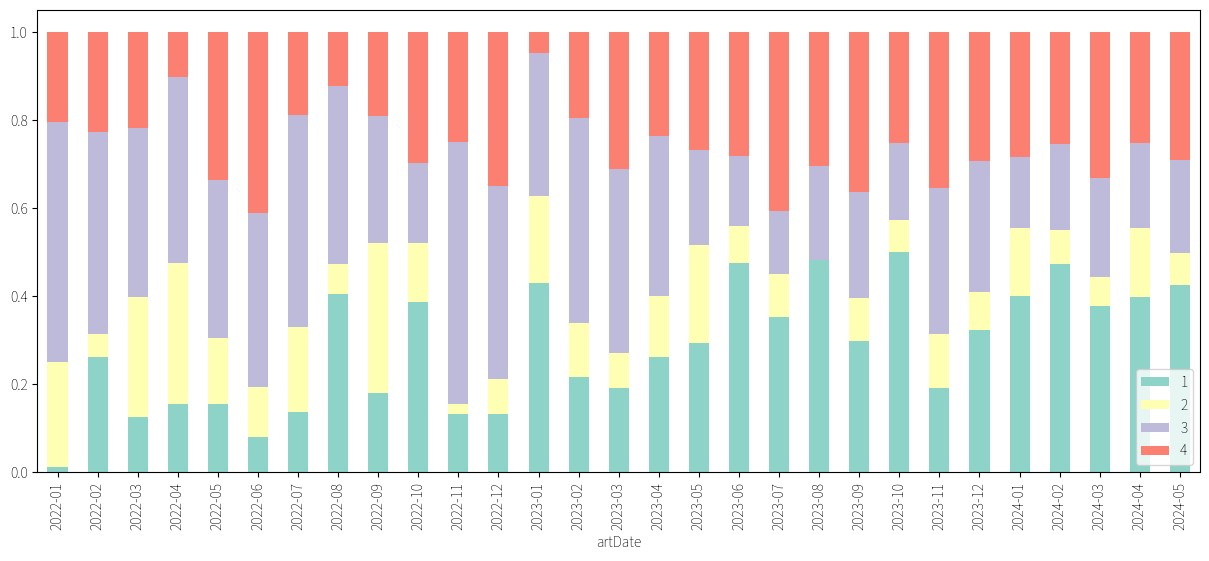

In [57]:
fig, ax = plt.subplots(figsize=(15, 6))
monthly_mean.plot.bar(ax=ax, stacked=True, color = plt.cm.Set3.colors)
ax.legend(loc='lower right')

主題一:科技股與半導體產業鏈（偏投資/財經）<br>

主題二:軟體工程與 AI 技術人才<br>

主題三:台灣半導體產業與供應鏈<br>

主題四:科技創新、企業管理與未來趨勢<br>

1. 科技股與半導體產業鏈（主題一，綠色）
   - 2022 前半年佔比較小，2022/08、2022/09、2023/01、2023/06 以後大幅提升。

   - 2023 下半年起維持相對高水位，代表近一年多「科技股與半導體產業鏈」逐漸成為媒體或討論焦點。

   - 可能與美中科技戰、輝達/台積電等業績、AI 投資潮等全球話題發酵有關。

2. 軟體工程與 AI 技術人才（主題二，黃色）
   - 2022 年中和 2023 年中佔比偶爾升高，平時波動較大。

   - 有明顯「高峰—低谷」交錯，但總體佔比沒有大幅成長或衰退。

   - 說明軟體工程與 AI 人才話題持續存在，偶爾因人才荒、AI 熱潮或求職季等議題升溫。

3. 台灣半導體產業與供應鏈（主題三，紫色）
   - 2022 年初至 2023 年初佔比最高，後期逐漸下降，被主題一（科技股投資）取代。

   - 這符合 2022 年半導體供應鏈高度關注，2023 年以後全球關注焦點由「供應鏈」逐步轉向「財經股市」和「企業發展」。

4. 科技創新、企業管理與未來趨勢（主題四，紅色）
   - 全時期佔比都很穩定、偏高，幾乎所有月份都是四個主題中最大一塊。

   - 說明無論科技或產業發展，企業創新、管理、未來趨勢都是長期熱門討論主題。

   - 可能受疫情、AI、企業裁員、數位轉型等話題影響，始終是討論重點。

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 8: GuidedLDA主題分佈</div>

In [58]:
guided_df=df.copy()
guided_df.head(3)

,content,artUrl,artCatagory,artDate,words,topic_label
0,實習公司名稱普匯金融科技工作職缺徵求條件商管相關科系或曾經接觸相關領域關注時事議題對國內外金...,https://www.ptt.cc/bbs/Finance/M.1644917373.A....,Finance,2022-02-15 17:29:30,"[實習, 普匯, 金融科技, 職缺, 徵求, 商管, 科系, 關注, 時事, 議題, 國內外...",3
1,中央社記者張璦台北日電台灣銀行消金企金政府部門業務三駕馬車再發威董事長呂桔誠今天表示台銀今年...,https://www.ptt.cc/bbs/Finance/M.1653071365.A....,Finance,2022-05-21 02:29:23,"[中央社, 張璦, 台北日電, 台灣, 銀行, 消金, 企金, 部門, 業務, 三駕, 馬車...",4
2,記者陳美君台北報導年月日週二上午擁抱金飯碗的機會來了中央銀行近日公開徵才開出的職缺包括經濟金...,https://www.ptt.cc/bbs/Finance/M.1676346325.A....,Finance,2023-02-14 11:45:19,"[陳美君, 台北, 週二, 金飯碗, 中央, 銀行, 近日, 公開, 徵才, 開出, 職缺,...",3


In [59]:
# 獲取每篇文章的主題分布
doc_topic = model.doc_topic_
doc_topic[100]

array([1.14279184e-05, 1.14279184e-05, 9.99954288e-01, 1.14279184e-05,
       1.14279184e-05])

In [60]:
guided_df['topic_label'] = doc_topic.argmax(axis=1) + 1

In [61]:
guided_df['topic_label'].value_counts()

topic_label
1    514
2    509
5    477
4    444
3    228
Name: count, dtype: int64

In [62]:
guided_df.head()

,content,artUrl,artCatagory,artDate,words,topic_label
0,實習公司名稱普匯金融科技工作職缺徵求條件商管相關科系或曾經接觸相關領域關注時事議題對國內外金...,https://www.ptt.cc/bbs/Finance/M.1644917373.A....,Finance,2022-02-15 17:29:30,"[實習, 普匯, 金融科技, 職缺, 徵求, 商管, 科系, 關注, 時事, 議題, 國內外...",4
1,中央社記者張璦台北日電台灣銀行消金企金政府部門業務三駕馬車再發威董事長呂桔誠今天表示台銀今年...,https://www.ptt.cc/bbs/Finance/M.1653071365.A....,Finance,2022-05-21 02:29:23,"[中央社, 張璦, 台北日電, 台灣, 銀行, 消金, 企金, 部門, 業務, 三駕, 馬車...",1
2,記者陳美君台北報導年月日週二上午擁抱金飯碗的機會來了中央銀行近日公開徵才開出的職缺包括經濟金...,https://www.ptt.cc/bbs/Finance/M.1676346325.A....,Finance,2023-02-14 11:45:19,"[陳美君, 台北, 週二, 金飯碗, 中央, 銀行, 近日, 公開, 徵才, 開出, 職缺,...",3
3,證交所徵才開創數位驅動時代報名至止中央社年月日週一下午中央社記者潘智義台北年月日電台灣證券交...,https://www.ptt.cc/bbs/Finance/M.1698684536.A....,Finance,2023-10-31 00:48:54,"[證交所, 徵才, 開創, 數位, 時代, 報名, 中央社, 中央社, 潘智義, 台北, 日...",4
4,版禁止張貼違反就業服務法性別平等工作法勞基法與其他法律之文章發文者已同意一切遵循現行法律並確...,https://www.ptt.cc/bbs/job/M.1641165773.A.E67....,job,2022-01-03 07:22:51,"[禁止張貼, 違反就業, 服務法性別平等, 工作法勞基法, 文章發文, 同意, 確知文責, ...",3


In [63]:
guided_df['artDate'] = pd.to_datetime(guided_df['artDate'])
guided_df.head(3)

,content,artUrl,artCatagory,artDate,words,topic_label
0,實習公司名稱普匯金融科技工作職缺徵求條件商管相關科系或曾經接觸相關領域關注時事議題對國內外金...,https://www.ptt.cc/bbs/Finance/M.1644917373.A....,Finance,2022-02-15 17:29:30,"[實習, 普匯, 金融科技, 職缺, 徵求, 商管, 科系, 關注, 時事, 議題, 國內外...",4
1,中央社記者張璦台北日電台灣銀行消金企金政府部門業務三駕馬車再發威董事長呂桔誠今天表示台銀今年...,https://www.ptt.cc/bbs/Finance/M.1653071365.A....,Finance,2022-05-21 02:29:23,"[中央社, 張璦, 台北日電, 台灣, 銀行, 消金, 企金, 部門, 業務, 三駕, 馬車...",1
2,記者陳美君台北報導年月日週二上午擁抱金飯碗的機會來了中央銀行近日公開徵才開出的職缺包括經濟金...,https://www.ptt.cc/bbs/Finance/M.1676346325.A....,Finance,2023-02-14 11:45:19,"[陳美君, 台北, 週二, 金飯碗, 中央, 銀行, 近日, 公開, 徵才, 開出, 職缺,...",3


In [64]:
# 按日期分組並計算每個主題標籤的相對頻率
guided_retrieve_date_topic = guided_df.groupby(df['artDate'].dt.date)['topic_label'].value_counts(normalize=True).unstack()
# 將日期設置為索引
guided_retrieve_date_topic.index = pd.to_datetime(guided_retrieve_date_topic.index)
guided_retrieve_date_topic=guided_retrieve_date_topic.fillna(0)
guided_retrieve_date_topic.sort_values(by='artDate', ascending=True)
# 重新取樣數據，按月取樣並獲取每個月的平均值
guided_monthly_mean = guided_retrieve_date_topic.resample('MS').mean()
# 顯示前幾行
guided_monthly_mean.head()

topic_label,1,2,3,4,5
artDate,,,,,
2022-01-01,0.200725,0.139130,0.298551,0.229710,0.131884
2022-02-01,0.106061,0.177273,0.295455,0.216667,0.204545
2022-03-01,0.182692,0.108974,0.227564,0.391026,0.089744
2022-04-01,0.087302,0.095238,0.436508,0.261905,0.119048
2022-05-01,0.260000,0.093333,0.300000,0.263333,0.083333


In [65]:
guided_monthly_mean.index = guided_monthly_mean.index.strftime('%Y-%m')
guided_monthly_mean.head()

topic_label,1,2,3,4,5
artDate,,,,,
2022-01,0.200725,0.139130,0.298551,0.229710,0.131884
2022-02,0.106061,0.177273,0.295455,0.216667,0.204545
2022-03,0.182692,0.108974,0.227564,0.391026,0.089744
2022-04,0.087302,0.095238,0.436508,0.261905,0.119048
2022-05,0.260000,0.093333,0.300000,0.263333,0.083333


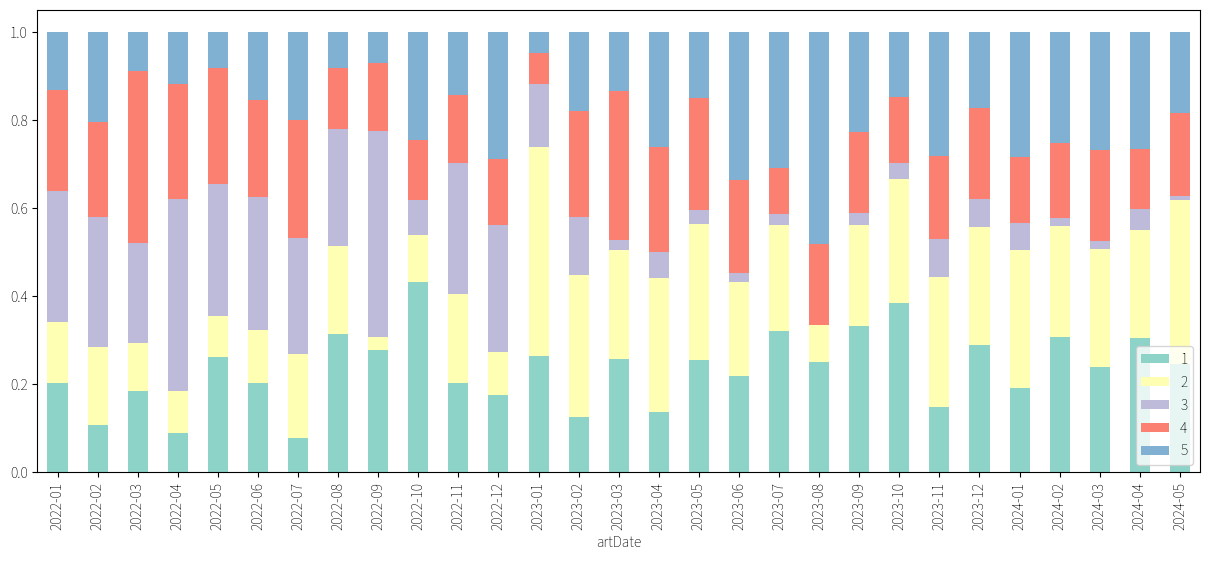

In [66]:
fig, ax = plt.subplots(figsize=(15, 6))
guided_monthly_mean.plot.bar(ax=ax, stacked=True, color = plt.cm.Set3.colors)
ax.legend(loc='lower right')

主題一:國際大型科技企業與產業領袖<br>

主題二:AI 技術發展與產業應用<br>

主題三:台灣半導體產業與供應鏈<br>

主題四:產業財經動態與投資分析<br>

主題五:人才職涯、學習與職場變遷<br>

1. 國際大型科技企業與產業領袖（主題一，最上方藍色）
   - 2023 年下半年明顯快速上升，成為目前最主要主題。

   - 2022 年底到 2023 年初比例開始提高，2023 年中以後佔比持續高於其他主題。

   - 這可能與 AI 大爆發（如 ChatGPT、輝達市值飆漲）、國際科技巨頭動態、企業領袖言論有關。

   - 代表現象： 近期全球科技巨頭與領袖的話題成為媒體與輿論焦點。

2. AI 技術發展與產業應用（主題二，黃綠色）
   - 全時期佔比穩定，但2023年後略有提升，尤其 2023 年中之後多數月份比例都有增加。

   - 顯示 AI 技術和產業應用話題近兩年討論度明顯上升，呼應產業AI化熱潮。

3. 台灣半導體產業與供應鏈（主題三，紫色）
   - 2022 年為主要焦點，2023 年後佔比明顯下降。

   - 這反映了 2022 年的半導體/供應鏈緊張、晶片荒議題，2023年之後，話題熱度被 AI 和國際大廠取代。

4. 產業財經動態與投資分析（主題四，紅色）
   - 2022 年初～2023 年初時有波動，2023 年後佔比穩定（但不是主流）。

   - 財經投資議題熱度會受到市場行情或單一重大事件影響，近期未見大幅變化。

5. 人才職涯、學習與職場變遷（主題五，青色，最下方）
   - 2022 年持平，2023 年中後佔比大幅提升，有時超越其他主題。

   - 反映疫情後，職涯變動、AI 衝擊就業、裁員潮、技能轉型成為焦點議題。

   - 尤其 2023 年中後，職場變動和人才議題在討論熱度明顯提升。